In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import sys
import os
sys.path.append('..')
from dataclasses import dataclass, field
from typing import Optional

import re
import numpy as np

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

from transformers import AutoConfig, AutoModel, AutoModelForSequenceClassification, AutoTokenizer
from transformers import GlueDataTrainingArguments as DataTrainingArguments, TrainingArguments
from transformers import GlueDataset, default_data_collator, Trainer, glue_compute_metrics

import seaborn
import matplotlib.pyplot as plt
from tqdm import trange

import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas

os.environ["WANDB_DISABLED"] = "true"

In [3]:
model_id = 'bert_base'
model_path = '/home/nlp/experiments/big_small/bert_base/epoch_4'

In [4]:
config = AutoConfig.from_pretrained(model_path, 
                                    num_labels=3)
#                                    output_attentions=True)

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                          config=config)

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [7]:
training_args = TrainingArguments(output_dir='/home/nlp/experiments/aug', no_cuda=True)

In [8]:
mnli_easy_data_args = DataTrainingArguments(task_name = 'mnli', 
                                       max_seq_length= 32,
                                       data_dir = '/home/nlp/cartography/filtered/' + model_id + '_easy_mnli/cartography_confidence_0.01/MNLI')

In [9]:
def draw(data, x, y, ax, cbar=False, layer=None):
    fig = seaborn.heatmap(data, xticklabels=x, square=True, yticklabels=y, 
          vmin=0.0, vmax=1.0, cbar=cbar, ax=ax, annot=False)
    fig = fig.get_figure()
    if layer:
        fig.savefig('heatmap_heuristics/' + str(layer+1) + '.pdf', dpi=400, bbox_inches='tight')
    else:
        fig.savefig('heatmap_heuristics/' + str(42) + '.pdf', dpi=400, bbox_inches='tight')

In [10]:
mnli_hard_data_args = DataTrainingArguments(task_name = 'mnli', 
                                       max_seq_length= 64,
                                       data_dir = '/home/nlp/cartography/filtered/' + model_id + '_hard_mnli/cartography_confidence_0.05/MNLI',
                                           overwrite_cache=True)

In [11]:
def put_on_cuda(model, batch):
    for k,v in batch.items():
        batch[k] = v.cuda()
    return model.cuda(), batch

In [12]:
def build_compute_metrics_fn(task_name):
    def compute_metrics_fn(p):
        preds = np.argmax(p.predictions, axis=1)
        return glue_compute_metrics('mnli', preds, p.label_ids)
    return compute_metrics_fn

In [13]:
# mnli_easy_dataset = GlueDataset(mnli_easy_data_args, tokenizer, mode="train")
mnli_hard_dataset = GlueDataset(mnli_hard_data_args, tokenizer, mode="train")

/home/nlp/.local/lib/python3.8/site-packages/transformers/data/datasets/glue.py:87: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(
/home/nlp/.local/lib/python3.8/site-packages/transformers/data/processors/glue.py:222: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/home/nlp/.local/lib/python3.8/site-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should

In [14]:
# mnli_easy_dataset_valid = GlueDataset(mnli_easy_data_args, tokenizer, mode="dev")
# mnli_hard_dataset_valid = GlueDataset(mnli_hard_data_args, tokenizer, mode="dev")

In [15]:
# mnli_easy_dl = DataLoader(mnli_easy_dataset, collate_fn = default_data_collator, batch_size=1, shuffle=True)
# mnli_hard_dl = DataLoader(mnli_hard_dataset, collate_fn = default_data_collator, batch_size=1, shuffle=True)

In [16]:
# easy_input = next(iter(mnli_easy_dl))
# hard_input = next(iter(mnli_hard_dl))
# easy_output = model(**easy_input)
# hard_output = model(**hard_input)
# # e, n, c

In [17]:
# easy_tok = tokenizer.tokenize(tokenizer.decode(easy_input['input_ids'][0]))#.replace('.', "").strip())
# hard_tok = tokenizer.tokenize(tokenizer.decode(hard_input['input_ids'][0]))#.replace('.', "").strip())

In [18]:
# easy_input['labels'], np.argmax(easy_output[1].detach(), axis=1), hard_input['labels'], np.argmax(hard_output[1].detach(), axis=1)

In [19]:
# aug = nac.RandomCharAug(action="insert", aug_char_p=0.1, aug_word_p=0.0)

# aug = nac.RandomCharAug(action="substitute", aug_char_p=0.1, aug_word_p=0.0)
# aug = nac.RandomCharAug(action="swap", aug_char_p=0.1, aug_word_p=0.0)
# aug = nac.RandomCharAug(action="delete", aug_char_p=0.1, aug_word_p=0.0)

aug = naw.WordEmbsAug(
    model_type='word2vec', model_path='/home/nlp/data/'+'GoogleNews-vectors-negative300.bin',
    action="insert", aug_p=0.1)

# aug = naw.WordEmbsAug(
#     model_type='word2vec', model_path=model_dir+'GoogleNews-vectors-negative300.bin',
#     action="substitute")



# aug = naw.ContextualWordEmbsAug(
#     model_path='bert-base-uncased', action="substitute")

# ins_aug = naw.ContextualWordEmbsAug(
#     model_path='bert-base-uncased', action="insert")

# word_emb = naw.WordEmbsAug(
#     model_type='fasttext', model_path='/home/nlp/data/wiki-news-300d-1M.vec',
#     action="substitute")

# aug = naw.SynonymAug(aug_src='wordnet')

In [76]:
# from nlpaug.util.file.download import DownloadUtil
# # DownloadUtil.download_word2vec(dest_dir='/home/nlp/data/')
# DownloadUtil.download_glove(model_name='glove.6B', dest_dir='/home/nlp/data')

In [144]:
org_text1 = "there was a lift, but tuppence chose to walk up"
org_text2 = "tuppence ran up the stairs."

text1 = "there was a lift, but tuppence chose to distance up"
text2 = "eightpence ran up the stairs."

tokenized_org_text = tokenizer(org_text1, org_text2, return_tensors='pt')
tokenized_text = tokenizer(text1, text2, return_tensors='pt')

In [145]:
output_org = model(**tokenized_org_text).logits.detach().numpy()[0]
output = model(**tokenized_text).logits.detach().numpy()[0]

In [146]:
output = (output - output.min()) / (output.max() - output.min())
output_org = (output_org - output_org.min()) / (output_org.max() - output_org.min())

In [147]:
np.max(output)/np.sum(output), label_dict[np.argmax(output)]

(0.54395413, 'contradiction')

In [148]:
output_org[np.argmax(output)]/np.sum(output_org), label_dict[np.argmax(output_org)]

(0.0, 'entailment')

In [77]:
# modified_dataset = []

def roberta_augment_dataset(aug, dataset):
    modified_dataset = []
    for i in trange(len(dataset)):
        text = tokenizer.decode(dataset[i].input_ids, skip_special_tokens=False)
        hypothesis = re.search('<s>(.+?)</s>', text).group(1)
        premise = re.search('</s>(.+?)</s>', text).group(1).replace('</s>', '')
        modified_hypothesis = aug.augment(hypothesis)
        modified_premise = aug.augment(premise)
        dict_output = tokenizer(modified_hypothesis, modified_premise, padding='max_length', max_length=128, truncation=True)
        dict_output['label'] = dataset[i].label
        modified_dataset.append(dict_output)
    return modified_dataset


def bert_augment_dataset(aug, dataset):
    modified_dataset = []
    for i in trange(len(dataset)):
        text = tokenizer.decode(dataset[i].input_ids, skip_special_tokens=False)
        hypothesis = re.search('[CLS](.+?)[PAD]', text).group(1).replace('LS] ', '').replace(' [SE', '')
        premise = re.search('[PAD](.+?)[PAD]', text).group(1).replace('] ', '').replace(' [SE', '')
        modified_hypothesis = aug.augment(hypothesis)
        modified_premise = aug.augment(premise)
        dict_output = tokenizer(modified_hypothesis, modified_premise, padding='max_length', max_length=128, truncation=True)
        dict_output['label'] = dataset[i].label
        modified_dataset.append(dict_output)
    return modified_dataset

In [82]:
augmented_dataset = bert_augment_dataset(aug, mnli_hard_dataset)

  2%|▏         | 444/19636 [03:03<2:12:24,  2.42it/s]


KeyboardInterrupt: 

In [29]:
label_dict = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}

In [46]:
trainer = Trainer(model=model,
                 args=training_args,
                 eval_dataset=augmented_dataset,
                 tokenizer=tokenizer,
                 data_collator=default_data_collator,
                 compute_metrics=build_compute_metrics_fn('mnli'))

In [33]:
original_preds = trainer.predict(mnli_hard_dataset)

/home/nlp/.local/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/home/nlp/.local/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [83]:
augmented_preds = trainer.predict(augmented_dataset)

/home/nlp/.local/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/home/nlp/.local/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [85]:
augmented_preds.metrics

{'eval_loss': 2.1363413333892822,
 'eval_mnli/acc': 0.13791549295774647,
 'eval_runtime': 314.8234,
 'eval_samples_per_second': 28.19}

In [39]:
# predicted_labels = []
# for pred in original_preds.predictions:
#     predicted_labels.append(np.argmax(pred))

In [86]:
flipped_labels = []
for i in range(len(augmented_dataset)):
    original_pr = np.argmax(original_preds.predictions[i])
    augmented_pr = np.argmax(augmented_preds.predictions[i])
    ground = original_preds.label_ids[i]
    if original_pr != ground:
        if augmented_pr == ground:
            flipped_labels.append(i)

In [87]:
len(flipped_labels)

2949

In [67]:
idx = flipped_labels[7]
tokenizer.decode(augmented_dataset[idx].input_ids, skip_special_tokens=True)

'holistic he uh was driver supposed to serve some agent time well pigeon he did cloudrack serve his time in in the uh the arrows militia he was supposed to faruqi go to particular jail.'

In [88]:
print(tokenizer.decode(mnli_hard_dataset[idx].input_ids, skip_special_tokens=True))
print(label_dict[np.argmax(original_preds.predictions[idx])], '-> ', label_dict[mnli_hard_dataset[idx].label])

specific techniques for handling multisite data sets matrix of categories, graphic data displays, tabulating frequency of different events, developing complex tabulations to check for relationships, and ordering information a general technique can enable you to do multiple things, including handling graphic data displays and tabulating frequency of different events.
neutral ->  entailment


In [151]:
heuristics = []
augmented_mistakes = 0
for idx in tqdm(range(5, len(augmented_dataset))):
    cur_loop_dict = {}
    label = label_dict[augmented_dataset[idx].pop('label')]
    hard_sample = tokenizer(tokenizer.decode(mnli_hard_dataset[idx].input_ids), return_tensors="pt")
    augmented_output = model(**augmented_dataset[idx])
    original_output = model(**hard_sample)
    # hard_sample['label'] = mnli_hard_dataset[idx]['label']
    augmented_label = label_dict[np.argmax(augmented_output.logits.detach().numpy())]
    original_label = label_dict[np.argmax(original_output.logits.detach().numpy())]
    if augmented_label == label and original_label != label:
        cur_loop_dict['Original label'] = label
        cur_loop_dict['Predicted label'] =  original_label
        cur_loop_dict['Original sentence'] = tokenizer.decode(mnli_hard_dataset[idx].input_ids, skip_special_tokens=True)
        cur_loop_dict['Augmented label'] = augmented_label
        cur_loop_dict['Augmented sentence'] = tokenizer.decode(augmented_dataset[idx].input_ids.tolist()[0], skip_special_tokens=True)
        heuristics.append(cur_loop_dict)
    if augmented_label != label and label == original_label:
        augmented_mistakes += 1
        
print(len(heuristics), augmented_mistakes)

100%|██████████| 277/277 [01:07<00:00,  4.10it/s]


In [153]:
print(len(heuristics))

33


In [381]:
idx = 28
print(heuristics[idx])
set(heuristics[idx]['Augmented sentence'].split(' ')) - set(heuristics[idx]['Original sentence'].split(' '))

{'Original label': 'entailment', 'Predicted label': 'neutral', 'Original sentence': 'it was sixteen years ago. she was sixteen years old when the dinosaurs came back to life.', 'Augmented label': 'entailment', 'Augmented sentence': 'it was thirty years ago. i was sixteen years old when the dinosaurs came back into us.'}


{'i', 'into', 'thirty', 'us.'}

In [ ]:
# dark - contra
# can't - entailment
# hulagi - contra
# struggle - contra
# dresser - contra
# all tokens have some prior notion regrading label, context doesn't matter

In [385]:
label_dict[np.argmax(model(**tokenizer('us', 
                                       'us into', return_tensors="pt")).logits.detach().numpy())]

'contradiction'

In [370]:
label_dict[np.argmax(model(**tokenizer('accordingly but just level with my unlawful taxpayers there was a hole in the rock', 
                "the hole in the rock was bigger than an adult", return_tensors="pt")).logits.detach().numpy())]

'contradiction'

In [214]:
label_dict[np.argmax(model(**tokenizer('I drop this', 'i did not drop it', return_tensors="pt")).logits.detach().numpy(), axis=1)[0]]

'entailment'

In [273]:
label_dict[np.argmax(model(**tokenizer('this is dark', 'this is not dark', return_tensors="pt")).logits.detach().numpy())]

'entailment'

In [290]:
label_dict[np.argmax(model(**tokenizer('do you think you can do it ?', 
                                       "do you think you can learn that?", 
                                       return_tensors="pt")).logits.detach().numpy())]

'contradiction'

In [331]:
label_dict[np.argmax(model(**tokenizer('mean', "mean whereever shrugs", return_tensors="pt")).logits.detach().numpy())]

'contradiction'

In [344]:
label_dict[np.argmax(model(**tokenizer('the shopkeeper paid the actor', 
                "the actor paid the lawyer", return_tensors="pt")).logits.detach().numpy())]

'entailment'

In [352]:
label_dict[np.argmax(model(**tokenizer("If the dresser slept, the dresser ran.", 
                "The dresser slept ", return_tensors="pt")).logits.detach().numpy())]

'entailment'

In [18]:
trainer = Trainer(model=model,
                 args=training_args,
                 eval_dataset=mnli_hard_dataset,
                 tokenizer=tokenizer,
                 data_collator=default_data_collator,
                 compute_metrics=build_compute_metrics_fn('mnli'))

In [19]:
trainer.evaluate()

/home/nlp/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/nlp/.local/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/home/nlp/.local/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: calvin (use `wandb login --relog

{'eval_loss': 2.006007194519043,
 'eval_mnli/acc': 0.21012426156039926,
 'eval_runtime': 75.3136,
 'eval_samples_per_second': 260.723}

In [143]:
# trainer.predict([mnli_hard_dataset_valid[0]])

In [ ]:
# hard 5%
# normal :                        15.63
# insert char randomly:           18.76
# Substitute character randomly   20.22
# Swap character randomly         19.33
# Delete character randomly       20.12
# Insert word randomly by word embeddings similarity (word2vec) 

In [33]:
tokenizer.convert_tokens_to_string(hard_tok), augmented_text

('[CLS] the metrics described here will generally be used after contract award, in order [SEP] the metrics are for after the contract gets awarded so then you can [SEP]',
 '[ CLS] the metric described hither bequeath generally be used after contract award, in society [sept] the metric function are for after the contract get awarded thence then you can [SEP ]')

In [504]:
augmented_output = model(torch.tensor([tokenizer.encode(hard_tok)]))
augmented_tok = tokenizer.tokenize(augmented_text)

In [505]:
np.argmax(augmented_output[0].detach(), axis=1) == hard_input['labels']

tensor([False])

In [454]:
easy_attentions = torch.cat(easy_output[-1]).to('cpu').detach().numpy()
hard_attentions = torch.cat(hard_output[-1]).to('cpu').detach().numpy()
augmented_attentions = torch.cat(augmented_output[-1]).to('cpu').detach().numpy()

In [455]:
avg_easy_attentions = []

for i in range(1, 4):
    for j in range(1, 4):
        avg_easy_attentions.append(easy_attentions[i][j])

avg_easy_attentions = sum(avg_easy_attentions)/len(avg_easy_attentions)

In [456]:
avg_hard_attentions = []

for i in range(1, 4):
    for j in range(1, 4):
        avg_hard_attentions.append(hard_attentions[i][j])

avg_hard_attentions = sum(avg_hard_attentions)/len(avg_hard_attentions)

In [457]:
avg_augmented_attentions = []

for i in range(1, 4):
    for j in range(1, 4):
        avg_augmented_attentions.append(augmented_attentions[i][j])

avg_augmented_attentions = sum(avg_augmented_attentions)/len(avg_augmented_attentions)

/home/nlp/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28165 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/nlp/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 28165 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/nlp/.local/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 28165 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/home/nlp/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28165 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/nlp/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 28165 missing from current font.
  font.set_text(s, 0, flags=flags)


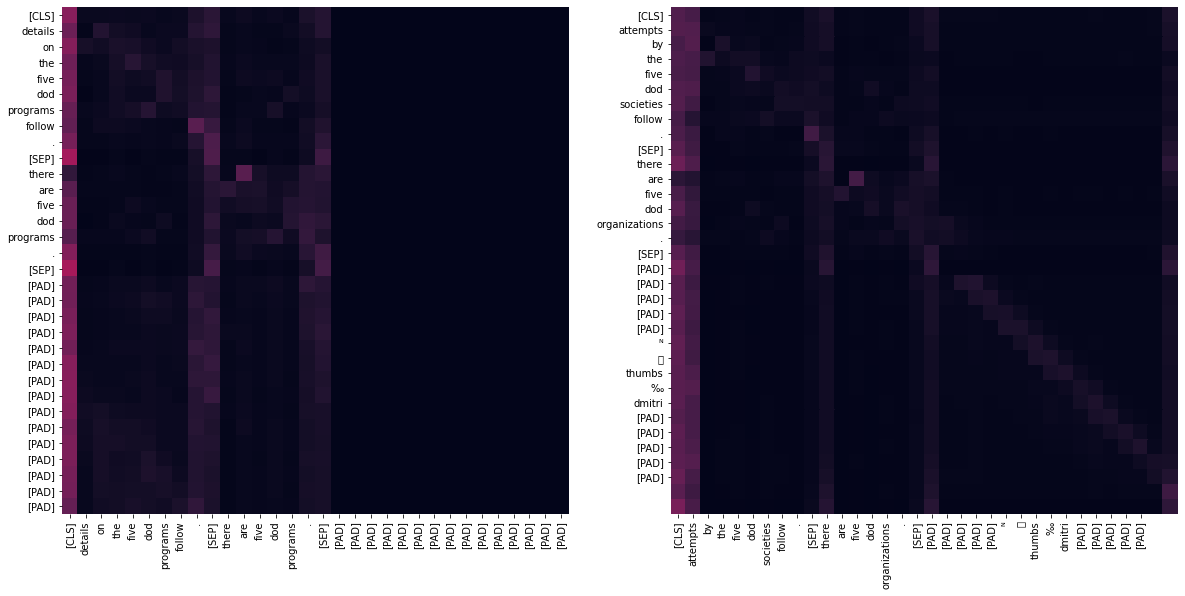

In [472]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))
# draw(avg_easy_attentions, easy_tok, easy_tok, ax=axs[0])
draw(avg_hard_attentions, hard_tok, hard_tok, ax=axs[0])
draw(avg_augmented_attentions, augmented_tok, augmented_tok, ax=axs[1])

TypeError: 'AxesSubplot' object is not subscriptable

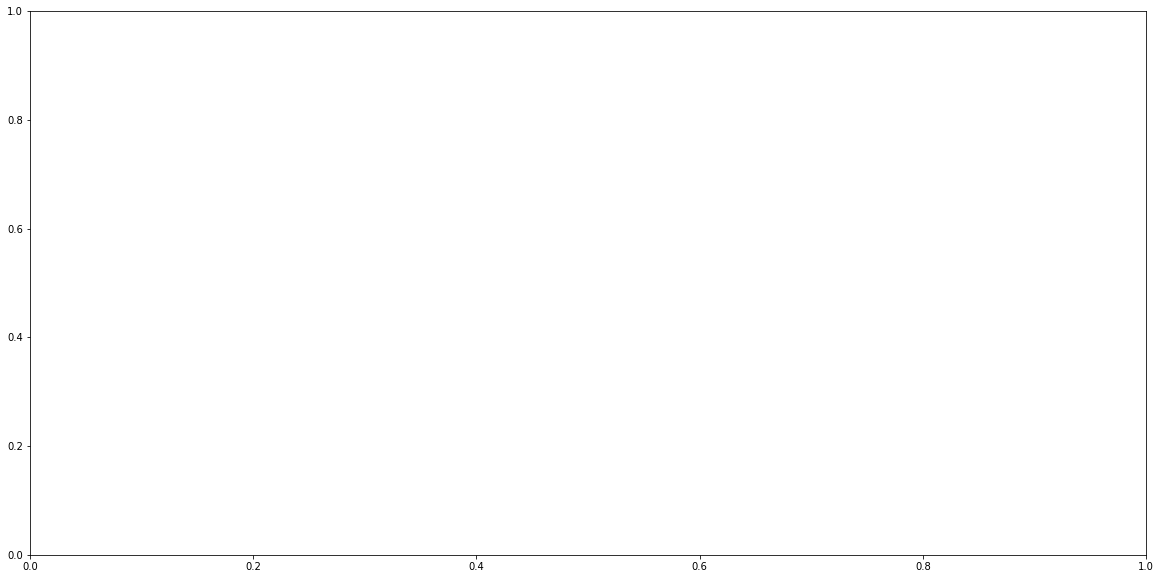